In [1]:
import numpy as np
import matplotlib.pyplot as plt

strain combinations

In [2]:
def ebot(etop):
    """
    strain on bottom such that strain at 3/7h from top is ec2 0.002
    :param etop: strain on top
    :return: strain at bottom
    """
    ebot = 4/3*(0.0035-etop)
    return ebot

In [3]:
fck = 30   
r = 1200

steps = 100
ec2 = 0.002
ecu2 = 0.0035
strain_comb_p1 = [(i, ebot(i)) for i in list(np.round(np.linspace(ec2, ecu2, steps, endpoint=False), 4))] #bottom strain non negative
strain_comb_p2 = [(ecu2, i) for i in list(np.round(np.linspace(0, -0.045, steps), 4))] #bottom strain negative

strain_comb = strain_comb_p1 + strain_comb_p2

In [4]:
def interpol_e(etop, ebot, steps):
    """
    interpolate strain for each strip given extreme strain values
    :param etop: strain at top
    :param ebot: strain at bottom
    :param steps: number of strips
    :return: list of strain for each strip
    """
    e = []
    for m in range(steps + 1):
        e.append(np.round(etop - (etop - ebot) * m / steps, 4))
    return e

In [5]:
def stress(ec2, fck):
    """
    stress strain relationship. refer to IRC: 112-2020 Cl. 6.4.2.8
    :param ec2: strain
    :param fck: fck of concrete
    :return: stress for giver strain ec2 for concrete of grade fck
    """
    if ec2 < 0:
        stress = 0
    elif 0 <= ec2 <= 0.002:
        stress = 0.67*fck/1.5 * (1 - np.power((1 - ec2 / 0.002), 2))
    else:
        stress = 0.67*fck/1.5
    return stress

In [6]:
def seg_area(h, r):
    """
    area of minor segment of a circle of radius r, made by chord at height h away from centre.
    :param h: distance of chord from centre
    :param r: radius of circle
    :return: area of minor segment
    """
    theta = np.arccos(h/r) * 2
    area = 1/2*r**2*(theta - np.sin(theta))
    return area

In [7]:
def pm(l, w, axis=0, n=50):
    """
    pm pair
    :param l: length of rectangle of wall type pier (along transverse direction w.r.to traffic direction)
    :param w: width of rectangle (also equal to diameter of circular ends)
    :param axis: 0, 1 for transverse axis, longitudinal axis respectively(w.r.to traffic dir)
    :param n: no of strips
    :return: pair of (m, p)
    """
    global fck
    global strain_comb
    r = w/2
    f = []
    m = []
    
    for i in strain_comb:
        st_top = i[0]
        st_bot = i[1]

        seg_e = np.array(interpol_e(st_top, st_bot, n))[1:]
        seg_stress = np.array([stress(i, fck) for i in seg_e])
        
        if axis == 0:
            seg_h = np.linspace(r, -r, n+1)
            seg_ar = np.array([seg_area(seg_h[i], r) - seg_area(seg_h[i-1], r) + l*w/n for i in range(1, len(seg_h))])
            
        if axis == 1:
            seg_h = np.linspace(l/2 + r, -(l/2 + r), n+1)
            seg_ar_lst = []
            for i in range(1, len(seg_h)):
                if r+l/2 > seg_h[i] >= l/2:
                    seg_ar_lst.append(seg_area(seg_h[i] - l/2, r) - seg_area(seg_h[i-1] - l/2, r))
                elif l/2 > seg_h[i] >= -l/2:
                    seg_ar_lst.append(w*(l+2*r)/n)
                elif -l/2 > seg_h[i] >= -(l/2 + r):
                    seg_ar_lst.append(seg_area(seg_h[i] + l/2, r) - seg_area(seg_h[i-1] + l/2, r))
            seg_ar = np.array(seg_ar_lst)
            
        seg_force = seg_stress * seg_ar
        f.append(seg_force.sum())

        seg_cg = seg_h[: -1] - r/n
        seg_m = seg_force * seg_cg
        m.append(seg_m.sum())
    return (m, f)

In [8]:
pm1 = pm(0, 2400)

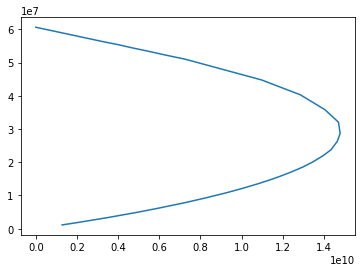

In [9]:
plt.plot(pm1[0], pm1[1])

In [10]:
fck = 30    
n = 50
r = 1200
f = []
m = []

for i in strain_comb:
    st_top = i[0]
    st_bot = i[1]

    seg_e = np.array(interpol_e(st_top, st_bot, n))[1:]
    seg_stress = np.array([stress(i, fck) for i in seg_e])

    seg_h = np.linspace(r, -r, n+1)

    seg_ar = np.array([seg_area(seg_h[i], r) - seg_area(seg_h[i-1], r) for i in range(1, len(seg_h))])
    seg_force = seg_stress * seg_ar
    f.append(seg_force.sum())

    seg_cg = seg_h[: -1] - r/n
    seg_m = seg_force * seg_cg
    m.append(seg_m.sum())
    

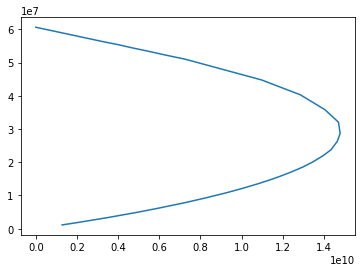

In [11]:
plt.plot(m,f)